In [ ]:
import numpy as np
import scanpy as sc
import cell2location
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42

In [ ]:
import mygene
import scanpy as sc

In [87]:
adata_vis = sc.read_visium("/root/data/LM_1")

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1899: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [88]:
# 假设 ENSG 号已经是 adata_ref.var 的索引或列
ensg_ids = adata_vis.var['gene_ids']  # 或 adata_ref.var['ENSG'].tolist() 如果 ENSG 号是一个列

In [89]:
adata_vis.obs['sample'] = list(adata_vis.uns['spatial'].keys())[0]

In [90]:
adata_vis.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

In [91]:
adata_vis.var['SYMBOL'] = adata_vis.var_names

In [92]:
adata_vis.var.set_index('gene_ids', drop=True, inplace=True)

In [93]:
adata_vis.var

,feature_types,genome,SYMBOL
gene_ids,,,
ENSG00000243485,Gene Expression,GRCh38,MIR1302-2HG
ENSG00000237613,Gene Expression,GRCh38,FAM138A
ENSG00000186092,Gene Expression,GRCh38,OR4F5
ENSG00000238009,Gene Expression,GRCh38,AL627309.1
ENSG00000239945,Gene Expression,GRCh38,AL627309.3
...,...,...,...
ENSG00000277836,Gene Expression,GRCh38,AC141272.1
ENSG00000278633,Gene Expression,GRCh38,AC023491.2
ENSG00000276017,Gene Expression,GRCh38,AC007325.1


In [119]:
adata_ref = sc.read("./data/LM_scRNA_for_C2L.h5ad")

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [120]:
adata_ref.var['SYMBOL'] = adata_ref.var.index

In [118]:
# 创建 mygene 查询器
mg = mygene.MyGeneInfo()

# 创建 mygene 查询器
mg = mygene.MyGeneInfo()

# 查询更新后的基因符号对应的 ENSEMBL ID
gene_symbols = adata_ref.var_names.tolist()
gene_info = mg.querymany(gene_symbols, scopes='symbol', fields='ensembl.gene', species='human')

# 提取 ENSG 号并创建映射
ensg_map = {}
for g in gene_info:
    if 'ensembl' in g:
        if isinstance(g['ensembl'], list):  # 处理返回多个结果的情况
            ensg_map[g['query']] = g['ensembl'][0]['gene']
        else:
            ensg_map[g['query']] = g['ensembl']['gene']
    else:
        ensg_map[g['query']] = None  # 处理没有结果的情况

# 将 ENSG 号添加到 adata_ref.var
adata_ref.var['GeneID-2'] = [ensg_map[g] for g in adata_ref.var_names]

# 检查添加的 ENSG 列
print(adata_ref.var)

36601 input query terms found no hit:	['None', 'ENSG00000237613', 'ENSG00000186092', 'None', 'None', 'None', 'None', 'None', 'None', 'None


KeyError: None

In [ ]:
# rename 'GeneID-2' as necessary for your data
adata_ref.var.set_index('GeneID-2', drop=True, inplace=True)

# delete unnecessary raw slot (to be removed in a future version of the tutorial)
del adata_ref.raw

In [ ]:
adata_ref.var.set_index

In [ ]:
adata_ref.var

In [ ]:
results_folder = './results/LM/'
# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

In [ ]:
adata_vis.var

In [ ]:
#去除空间转录组数据中线粒体基因的影响
adata_vis.var['MT_gene'] = [gene.startswith('MT-') for gene in adata_vis.var['SYMBOL']]
adata_vis.obsm['MT'] = adata_vis[:,adata_vis.var['MT_gene'].values].X.toarray()
adata_vis = adata_vis[:, ~adata_vis.var['MT_gene'].values]

In [ ]:
# 找出所有不为 None 的基因名称
valid_genes = [gene for gene in adata_ref.var['GeneID-2'] if gene is not None]

In [ ]:
# 仅保留那些基因名称不为 None 的基因
adata_ref = adata_ref[:, valid_genes].copy()

In [ ]:
adata_ref.var_names

In [105]:
#过滤低表达基因
from cell2location.utils.filtering import filter_genes
selected = filter_genes(adata_ref, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
adata_ref = adata_ref[:, selected].copy()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [106]:
adata_ref.obs

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,percent.ribo,seurat_clusters,Major_celltype,Mini_celltype,set,Patients,immunecells,sub_celltype,sub_sub_celltype,Subset
chang1_AAACCCAAGACAGTCG.1,chang1,2382.0,1319,4.408060,9.571788,5,T/ILC,CD4+,CRC,CRC1,immunecells,CD4,3,T/ILC
chang1_AAACCCAAGAGCCGTA.1,chang1,6150.0,2237,10.048780,9.154472,2,Fibroblasts,Fibroblasts,CRC,CRC1,nonimmunecells,Fibroblasts,45,Fibroblasts
chang1_AAACCCAAGCGTATGG.1,chang1,20604.0,5224,3.581829,15.613473,1,Endothelial,Endothelial,CRC,CRC1,nonimmunecells,Endothelial,31,Endothelial
chang1_AAACCCAAGGCATCAG.1,chang1,6761.0,2857,2.233397,5.546517,6,Endothelial,Endothelial,CRC,CRC1,nonimmunecells,Endothelial,29,Endothelial
chang1_AAACCCAAGGGTCACA.1,chang1,24065.0,5540,5.206732,15.969250,8,Endothelial,Endothelial,CRC,CRC1,nonimmunecells,Endothelial,37,Endothelial
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
gan2_TTTGGTTTCCTGTAAG.1,gan2,2932.0,1356,7.366985,0.511596,0,T/ILC,CD8+,LM,LM2,immunecells,CD4,0,T/ILC
gan2_TTTGTTGAGAAGCCTG.1,gan2,2679.0,1379,4.927212,0.671892,9,T/ILC,CD8+,LM,LM2,immunecells,MAIT,16,T/ILC
gan2_TTTGTTGCACCGTGAC.1,gan2,1408.0,964,4.900568,1.491477,6,Myeloid,Monocytes,LM,LM2,immunecells,Myeloid,19,Myeloid
gan2_TTTGTTGCACTTGACA.1,gan2,4660.0,1859,5.944206,2.231760,4,T/ILC,CD8+,LM,LM2,immunecells,CD8,10,T/ILC


In [21]:
#adata_ref.obs
cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                           batch_key='orig.ident',
                           labels_key='Subset'
                           #categorical_covariate_keys=['Method']
                          )

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/abc.py:119: FutureWarning: SparseDataset is deprecated and will be removed in late 2024. It has been replaced by the public classes CSRDataset and CSCDataset.

For instance checks, use `isinstance(X, (anndata.experimental.CSRDataset, anndata.experimental.CSCDataset))` instead.

For creation, use `anndata.experimental.sparse_dataset(X)` instead.

  return _abc_instancecheck(cls, instance)
An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [22]:
#cell2location.models.RegressionModel.setup_anndata(adata=adata_ref,
                        # 10X reaction / sample / batch
                       # batch_key='Sample',
                        # cell type, covariate used for constructing signatures
                       # labels_key='Subset'
                        # multiplicative technical effects (platform, 3' vs 5', donor effect)
                        #categorical_covariate_keys=['Method']
                       #)

In [23]:
from cell2location.models import RegressionModel
mod = RegressionModel(adata_ref)
mod.view_anndata_setup()

Anndata setup with scvi-tools version 1.0.4.

Setup via `RegressionModel.setup_anndata` with arguments:

{
│   'layer': None,
│   'batch_key': 'orig.ident',
│   'labels_key': 'Subset',
│   'categorical_covariate_keys': None,
│   'continuous_covariate_keys': None
}

         Summary Statistics         
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃     Summary Stat Key     ┃ Value ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│         n_batch          │   4   │
│         n_cells          │ 31304 │
│ n_extra_categorical_covs │   0   │
│ n_extra_continuous_covs  │   0   │
│         n_labels         │   6   │
│          n_vars          │ 18072 │
└──────────────────────────┴───────┘

               Data Registry                
┏━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Registry Key ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      X       │          adata.X          │
│    batch     │ adata.obs['_scvi_batch']  │
│    ind_x     │   adata.obs['_indices']   │
│    labels    │ adata.obs['_scvi_labels'] │
└──────────────┴───────────────────────────┘

                     batch State Registry                     
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['orig.ident'] │   chang1   │          0          │
│                         │   chang2   │          1          │
│                         │    gan1    │          2          │
│                         │    gan2    │          3          │
└─────────────────────────┴────────────┴─────────────────────┘

                   labels State Registry                   
┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location   ┃ Categories  ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['Subset'] │  B/Plasma   │          0          │
│                     │ Endothelial │          1          │
│                     │ Epithelial  │          2          │
│                     │ Fibroblasts │          3          │
│                     │   Myeloid   │          4          │
│                     │    T/ILC    │          5          │
└─────────────────────┴─────────────┴─────────────────────┘

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
You are using a CUDA device ('NVIDIA GeForce RTX 4070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_pre

Epoch 10/10: 100%|██████████| 10/10 [01:12<00:00,  7.22s/it, v_num=1, elbo_train=2.93e+8]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 10/10: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it, v_num=1, elbo_train=2.93e+8]


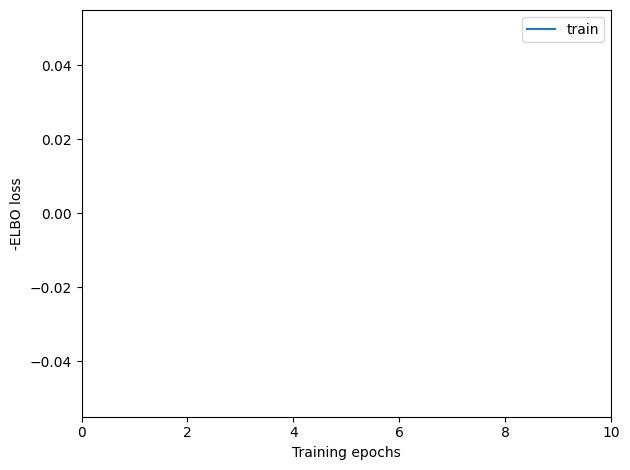

In [24]:
#训练模型，要在数据上实现收敛，需要增加max_epochs参数。如果服务器有GPU，将use_gpu设置成True将显著加快训练速度。
mod.train(max_epochs=10, use_gpu=True)
mod.plot_history(20)

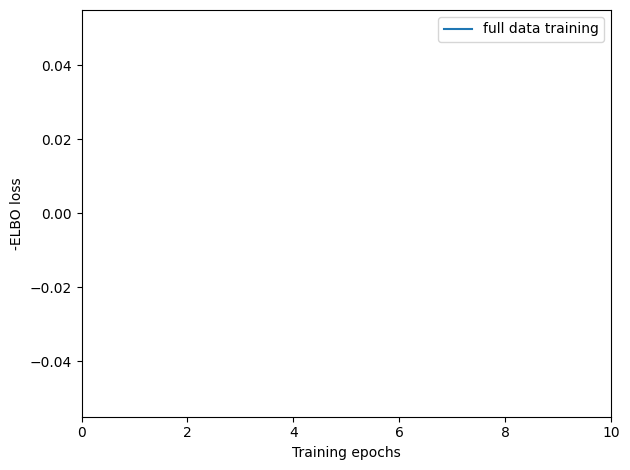

In [25]:
mod.plot_history(1000)
plt.legend(labels=['full data training'])

In [26]:
#基于后验分布，计算基因在cluster中的表达
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:15<00:00, 62.52it/s]


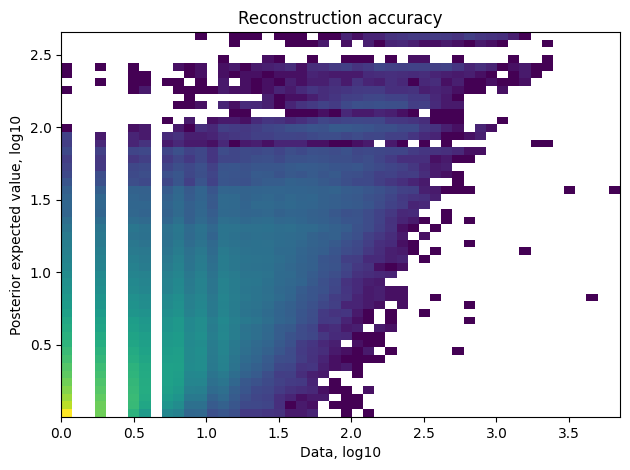

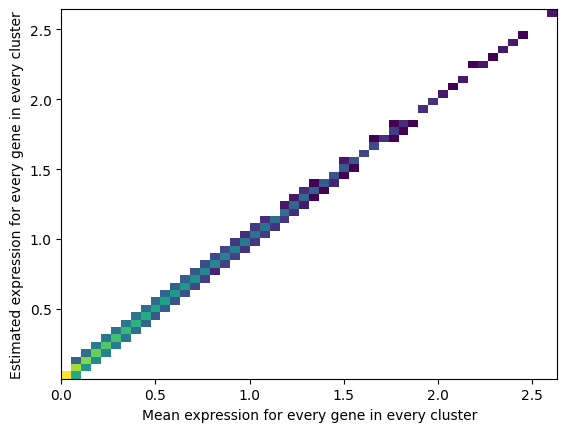

In [27]:
# Save model
mod.save(f"{ref_run_name}", overwrite=True)
mod.plot_QC()

In [28]:
# In this section, we export the estimated cell abundance (summary of the posterior distribution).
adata_ref = mod.export_posterior(
    adata_ref, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
)

# Save model
mod.save(f"{ref_run_name}", overwrite=True)

# Save anndata object with results
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref.write(adata_file)
adata_file

/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/model/base/_pyromixin.py:388: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  _, _, device = parse_device_args(


Sampling global variables, sample: 100%|██████████| 999/999 [00:16<00:00, 61.94it/s]


'./results/LM//reference_signatures/sc.h5ad'

In [29]:
adata_file = f"{ref_run_name}/sc.h5ad"
adata_ref = sc.read_h5ad(adata_file)
mod = cell2location.models.RegressionModel.load(f"{ref_run_name}", adata_ref)

INFO     File ./results/LM//reference_signatures/model.pt already downloaded                                       


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/639:   0%|          | 1/639 [00:00<07:04,  1.50it/s, v_num=1]

`Trainer.fit` stopped: `max_steps=1` reached.


Epoch 1/639:   0%|          | 1/639 [00:00<07:09,  1.49it/s, v_num=1]


In [30]:
#负二项式回归模型的所有参数都导出到参考 anndata 对象中，但是对于空间映射，我们只需要每种细胞类型中每个基因的估计表达。在这里，我们从标准输出中提取：
#因为批次的问题，计算出来的特征基因的表达和平均表达并不相同
if 'means_per_cluster_mu_fg' in adata_ref.varm.keys():
    inf_aver = adata_ref.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()
else:
    inf_aver = adata_ref.var[[f'means_per_cluster_mu_fg_{i}' for i in adata_ref.uns['mod']['factor_names']]].copy()

inf_aver.columns = adata_ref.uns['mod']['factor_names']
inf_aver.iloc[0:5, 0:5]

,B/Plasma,Endothelial,Epithelial,Fibroblasts,Myeloid
SYMBOL,,,,,
LINC01409,0.049966,0.037168,0.231008,0.051046,0.056599
LINC01128,0.084836,0.181193,0.163902,0.162477,0.139692
SAMD11,0.000637,0.005226,0.008693,0.041055,0.001796
NOC2L,0.074754,0.307170,0.550528,0.289314,0.111864
AL645608.7,0.001475,0.043048,0.015445,0.117834,0.026350


In [58]:
#筛选交集基因
# find shared genes and subset both anndata and reference signatures
intersect = np.intersect1d(adata_vis.var_names, inf_aver.index)

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [67]:
adata_vis.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', name='SYMBOL', length=36588)

In [68]:
inf_aver.index

Index(['A1BG', 'A1BG-AS1', 'A1CF', 'A2M', 'A2M-AS1', 'A4GALT', 'AAAS', 'AACS',
       'AADAC', 'AADACL2-AS1',
       ...
       'ZSWIM9', 'ZUP1', 'ZW10', 'ZWILCH', 'ZWINT', 'ZXDC', 'ZYG11A', 'ZYG11B',
       'ZYX', 'ZZEF1'],
      dtype='object', name='SYMBOL', length=18057)

In [69]:
# 移除重复元素
intersect_unique = list(set(intersect))
# 检查是否有重复元素被移除
if len(intersect) != len(intersect_unique):
    print("Duplicate elements were found and removed.")
    intersect = intersect_unique

In [70]:
intersect = [item for item in intersect if item in adata_vis.var_names]

In [71]:
adata_vis.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', name='SYMBOL', length=36588)

In [72]:
inf_aver = inf_aver.loc[intersect, :].copy()

In [73]:
adata_vis

AnnData object with n_obs × n_vars = 3373 × 36588
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', '_indices', '_scvi_batch', '_scvi_labels'
    var: 'gene_ids', 'feature_types', 'genome', 'SYMBOL', 'MT_gene'
    uns: 'spatial', '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'spatial', 'MT'

In [74]:
adata_vis = adata_vis[: ,intersect].copy()

InvalidIndexError: Reindexing only valid with uniquely valued Index objects

In [61]:
adata_vis.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', name='SYMBOL', length=36588)

In [62]:
# prepare anndata for cell2location model
cell2location.models.Cell2location.setup_anndata(adata=adata_vis, batch_key="sample")

In [63]:
#N_cells_per_location：每个点包含的细胞数量
#detection_alpha：如果切片间或者批次间RNA检测存在大的变异性，detection_alpha设置为20，反之可以设置为200。
mod = cell2location.models.Cell2location(
   adata_vis, cell_state_df=inf_aver,
   N_cells_per_location=30,
   detection_alpha=20
)
mod.view_anndata_setup()

ValueError: Lengths must match to compare

In [83]:
mod.train(max_epochs=3000,
          # train using full data (batch_size=None)
          batch_size=None,
          # use all data points in training because
          # we need to estimate cell abundance at all locations
          train_size=1,
          use_gpu=True,
         )


/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/train/_trainrunner.py:76: UserWarning: `use_gpu` is deprecated in v1.0 and will be removed in v1.1. Please use `accelerator` and `devices` instead.
  accelerator, lightning_devices, device = parse_device_args(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/trainer/configuration_validator.py:69: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/lightning/pytorch/loops/fit_loop.py:281: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=10). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


ValueError: Expected parameter rate (Tensor of shape (1, 1)) of distribution Gamma(concentration: tensor([[10.]], device='cuda:0'), rate: tensor([[nan]], device='cuda:0')) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[nan]], device='cuda:0')
               Trace Shapes:               
                Param Sites:               
               Sample Sites:               
               m_g_mean dist         |  1 1
                       value         |  1 1
        m_g_alpha_e_inv dist         |  1 1
                       value         |  1 1
                    m_g dist         |  1 0
                       value         |  1 0
 n_s_cells_per_location dist 3373  1 |     
                       value 3373  1 |     
b_s_groups_per_location dist 3373  1 |     
                       value 3373  1 |     
    z_sr_groups_factors dist 3373 50 |     
                       value 3373 50 |     
 k_r_factors_per_groups dist         | 50 1
                       value         | 50 1
        x_fr_group2fact dist         | 50 6
                       value         | 50 6
                   w_sf dist 3373  6 |     
                       value 3373  6 |     

In [ ]:
# plot ELBO loss history during training, removing first 100 epochs from the plot
mod.plot_history(1000)
plt.legend(labels=['full data training']);